# Imports

In [1]:
from imports import *
from hyperparameters import Hyperparameters
from trial_function import TrialFunction
from metropolis_sampler import MetropolisSampler

# Training procedure

In [2]:
def train(
    trialFunction: TrialFunction,
    hyperparameters: Hyperparameters
):
    """Trains trial function"""
    initialTime = time.time()
    timeHistory = [None] * hyperparameters.numberOfTrainingSteps
    lossHistory = {
        'total loss' : [None] * hyperparameters.numberOfTrainingSteps,
        'total squered residual' : [None] * hyperparameters.numberOfTrainingSteps,
        'total normalisation error' : [None] * hyperparameters.numberOfTrainingSteps,
        'total orthogonalisation error' : [None] * hyperparameters.numberOfTrainingSteps
    }
    eHistory = [None] * hyperparameters.numberOfTrainingSteps
    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=hyperparameters.initialLearningRate,
        weight_decay=hyperparameters.weightDecay,
    )
    lossFunction = nn.MSELoss()
    print(
        "Step, Time [s], Residual-term, Normalization-term,"
        + " Orthogonalization-term, Sorted energies"
    )
    for stepNumber in range(hyperparameters.numberOfTrainingSteps):
        if stepNumber == 0:
            sampler = MetropolisSampler(hyperparameters)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(trialFunction.weightFunction)
        # Loss function
        r = trialFunction.totalSqueredResidual(sampler.sample)
        a = trialFunction.totalNormalisationError(sampler.sample)
        b = trialFunction.totalOrthogonalisationError(sampler.sample)
        e = trialFunction.spectrum(sampler.sample)
        loss = lossFunction(
            hyperparameters.residualTermWeight * r
            + hyperparameters.normalisationTermWeight * a
            + hyperparameters.orthogonalisationTermWeight * b
            + hyperparameters.energyTermWeight * torch.sum(e),
            torch.tensor(0.0).to(hyperparameters.device),
        )
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save some history
        timeHistory[stepNumber] = time.time() - initialTime
        if np.isnan(loss.item()):
            torch.save(trialFunc.state_dict(), trialFunc.PATH)
            print("LOSS IS NAN (model has been saved)")
            sys.exit(1)
        lossHistory['total loss'][stepNumber] = loss.item()
        lossHistory['total squered residual'][stepNumber] = r.cpu().detach().numpy()
        lossHistory['total normalisation error'][stepNumber] = a.cpu().detach().numpy()
        lossHistory['total orthogonalisation error'][stepNumber] = b.cpu().detach().numpy()
        eHistory[stepNumber] = e.cpu().detach().numpy()
        # Release some memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Print the state of the model
        if stepNumber % 100 == 0:
            print(
                f"{stepNumber},"
                + f" {timeHistory[stepNumber]:.2f},"
                + f" {r.cpu().detach().numpy():.4e},"
                + f" {a.cpu().detach().numpy():.4e}," 
                + f" {b.cpu().detach().numpy():.4e},"
                + f" {np.sort(eHistory[stepNumber])}"
            )
    return timeHistory, lossHistory, eHistory        

# 3D

## Hyperparameters

In [6]:
hyperparameters = Hyperparameters("../hyperparameters/hyperparameters_3d.csv")
pd.read_csv("../hyperparameters/hyperparameters_3d.csv")

,name,value
0,activation function,sin
1,amplitude function,gaussian
2,hidden layer size,100
3,coordinate space dimension,3
4,number of states,5
5,batch size,8192
6,initial learning rate,0.001
7,weight decay,0.001
8,residual term weight,1.0
9,normalisation term weight,1.0


## 1)

In [7]:
trialFunction = TrialFunction(
    hyperparameters,
    "3d_1"
)

timeHistory, lossHistory, eHistory = train(
    trialFunction,
    hyperparameters
)

torch.save(trialFunction.state_dict(), trialFunction.PATH)

Step, Time [s], Residual-term, Normalization-term, Orthogonalization-term, Sorted energies
0, 1.25, 6.7028e+03, 2.3343e-03, 1.5372e-02, [22.839048 24.823381 33.24457  33.70387  37.46895 ]
100, 25.63, 3.4414e+02, 1.2774e-01, 8.2840e-02, [ 5.282317  9.223183  9.229993  9.638025 10.057794]
200, 50.70, 2.3727e+02, 1.2321e-01, 5.9173e-02, [4.4777637 7.9354725 7.9595337 7.98673   8.855317 ]
300, 75.73, 1.8136e+02, 1.4853e-01, 5.3755e-02, [3.9022577 6.902171  7.00541   7.3758554 8.241263 ]
400, 99.27, 1.5296e+02, 1.6484e-01, 5.0932e-02, [3.6308508 6.323971  6.4489923 6.9138556 7.749654 ]
500, 122.82, 1.2858e+02, 1.6847e-01, 3.9079e-02, [3.5632377 5.7115855 6.025506  6.5690184 7.41338  ]
600, 145.46, 1.1235e+02, 1.4594e-01, 3.1069e-02, [3.4321027 5.386284  5.6831813 6.1907783 6.9665756]
700, 168.51, 9.9571e+01, 1.5600e-01, 2.8871e-02, [3.3265069 4.9863663 5.472557  6.042095  6.7980623]
800, 193.30, 8.7198e+01, 1.4744e-01, 2.7102e-02, [3.2842162 4.661875  5.287363  5.8091497 6.499066 ]
900, 217

KeyboardInterrupt: 

In [ ]:
trialFunction = TrialFunction(
    hyperparameters,
    "3d_2"
)

timeHistory, lossHistory, eHistory = train(
    trialFunction,
    hyperparameters
)

torch.save(trialFunction.state_dict(), trialFunction.PATH)

In [ ]:
trialFunction = TrialFunction(
    hyperparameters,
    "3d_3"
)

timeHistory, lossHistory, eHistory = train(
    trialFunction,
    hyperparameters
)

torch.save(trialFunction.state_dict(), trialFunction.PATH)

In [8]:
params = [None] * 8
j = 0
for i in (list(trialFunction.parameters())):
    params[j]=list(i.detach().cpu().numpy().reshape(-1))
    j = j+1
    print(type(i), i.shape)

<class 'torch.nn.parameter.Parameter'> torch.Size([100, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


1.4327866 -1.178184
0.8475522 -0.8151284


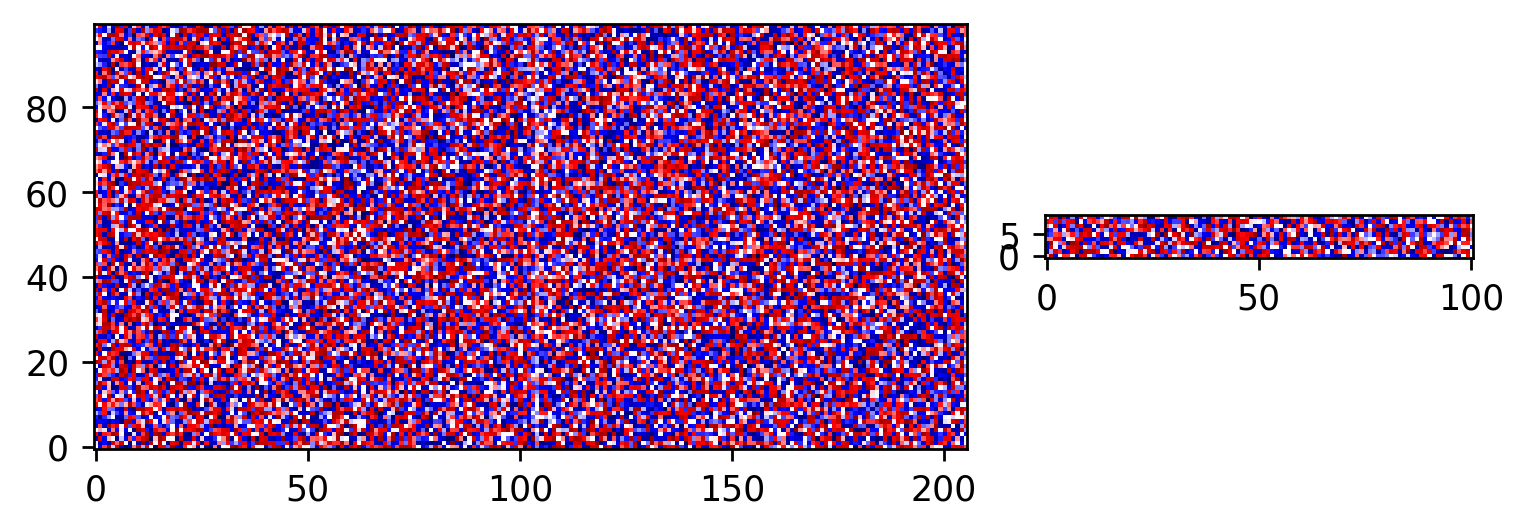

In [9]:
fig = plt.figure(layout='constrained', dpi=250)

gs = fig.add_gridspec(100,4+101+101+101)

from matplotlib import colors
# ax[1] = fig.add_subplot(gs[:,4:4+101])
# ax[2] = fig.add_subplot(gs[:,4+101:4+101+101])


a = []
for i in range(6):
    a.extend(params[i])
print(max(a), min(a))
ax = fig.add_subplot(gs[:,:4+101+101])
ax.imshow(
    np.array(a).reshape(-1,100).transpose(),
    origin='lower',
    cmap='seismic',
    # vmax=1,vmin=-1,
    norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-1.0, vmax=1.0, base=10),
)

a = params[6]
a.extend(params[7])
print(max(a), min(a))

ax = fig.add_subplot(gs[:,4+101+101:])
ax.imshow(
    np.array(a).reshape(-1,10).transpose(),
    origin='lower',
    cmap='seismic',
    # vmax=1,vmin=-1,
    norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-1.0, vmax=1.0, base=10),
)

In [11]:
list(trialFunction.parameters())[0].shape

torch.Size([100, 3])

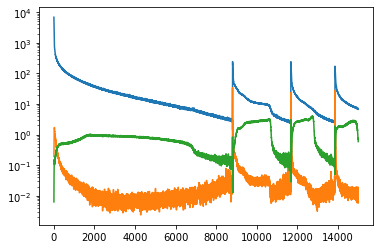

In [12]:
plt.plot(lossHistory['total squered residual'])
plt.plot(lossHistory['total orthogonalisation error'])
plt.plot(lossHistory['total normalisation error'])
plt.yscale("log")

[Text(0, 0, '0'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000'),
 Text(11000, 0, '11000'),
 Text(12000, 0, '12000'),
 Text(13000, 0, '13000'),
 Text(14000, 0, '14000'),
 Text(15000, 0, '15000')]

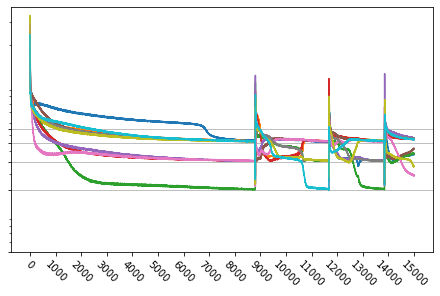

In [23]:
fig, ax = plt.subplots(1,1,layout='constrained')

ax.plot(eHistory)
ax.set_yscale("log")
ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
ax.grid(axis='y')
ax.set_xticks(list(range(15001))[::1000])
ax.set_xticklabels(list(range(15001))[::1000], rotation=-45)